In [1]:
from numpy import *
import matplotlib.pyplot as plt 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import preprocessing
import pandas as pd

# Evaluation of Best Classification Model Using GridSearchCV

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Thesis Resources/dataset/NoSql_Injection/NoSqli_Dataset.csv")
df.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,ClassLabel
0,0,0,0,1,1,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [3]:

X = df.drop(['ClassLabel'],axis='columns')
Y = df['ClassLabel']

In [4]:
Y.value_counts()

0    801
1    203
Name: ClassLabel, dtype: int64

In [5]:
X.head(2)

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0,0,0,1,1,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0


In [6]:
Y.head(5)

0    0
1    1
2    0
3    0
4    0
Name: ClassLabel, dtype: int64

In [7]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None)),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },

    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },


}

In [8]:
scores = []

target_names = ['Not Malicious', 'Malicious']

ConfusionMatrix={}
for model_name, mp in model_params.items():
    grid =  GridSearchCV(mp['model'],param_grid= mp['params'], cv=5, return_train_score=False,n_jobs=-1)
    grid.fit(X, Y)
    y_pred=grid.best_estimator_.predict(X)
    print('-------------------------------------------')
    print(model_name)  
    print('-------------------------------------------')
    print(classification_report(Y, y_pred, target_names=target_names))
    ConfusionMatrix[model_name]=confusion_matrix(Y, y_pred)
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        
    
    })


    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

-------------------------------------------
svm
-------------------------------------------
               precision    recall  f1-score   support

Not Malicious       0.93      0.99      0.96       801
    Malicious       0.97      0.72      0.82       203

     accuracy                           0.94      1004
    macro avg       0.95      0.86      0.89      1004
 weighted avg       0.94      0.94      0.93      1004

-------------------------------------------
decision_tree
-------------------------------------------
               precision    recall  f1-score   support

Not Malicious       0.94      1.00      0.97       801
    Malicious       0.97      0.75      0.85       203

     accuracy                           0.95      1004
    macro avg       0.96      0.87      0.91      1004
 weighted avg       0.95      0.95      0.94      1004

-------------------------------------------
Adaboost
-------------------------------------------
               precision    recall  f1-scor

,model,best_score,best_params
0,svm,0.918343,"{'C': 20, 'kernel': 'poly'}"
1,decision_tree,0.914358,"{'criterion': 'entropy', 'max_depth': None}"
2,Adaboost,0.918338,"{'base_estimator__criterion': 'gini', 'base_es..."
3,random_forest,0.912363,{'n_estimators': 5}
4,logistic_regression,0.904398,{'C': 1}
5,Naive_Bayes:BernoulliNB,0.878517,{'alpha': 1.0}


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


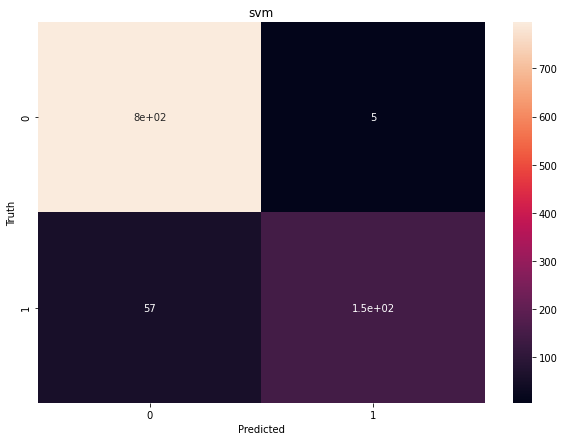

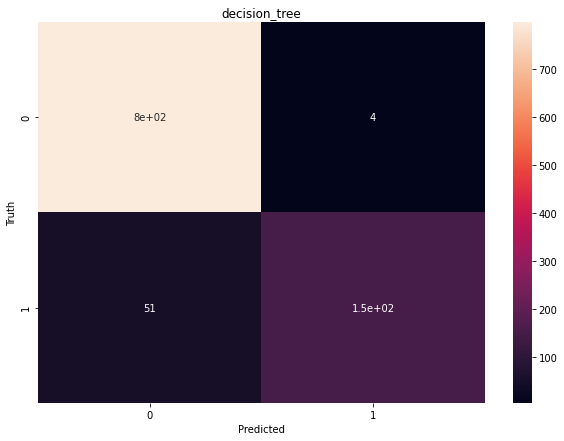

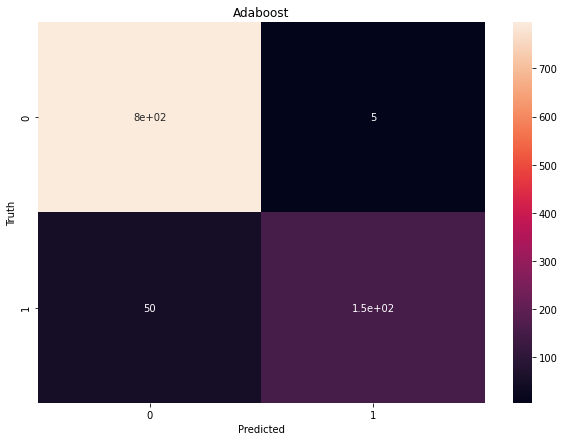

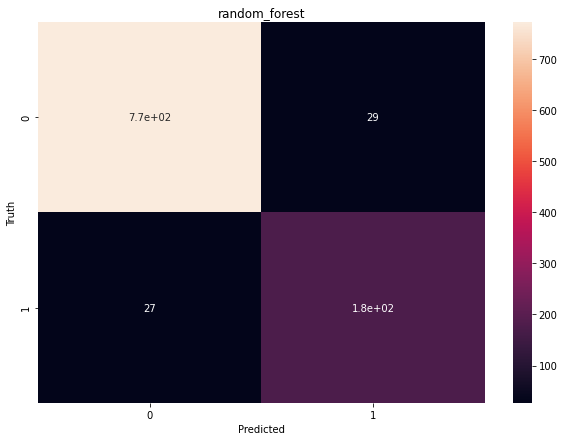

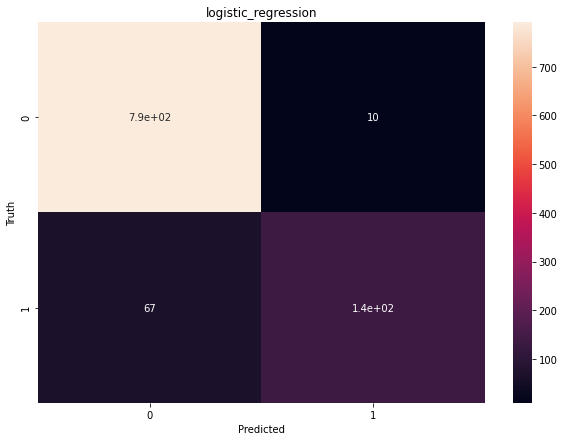

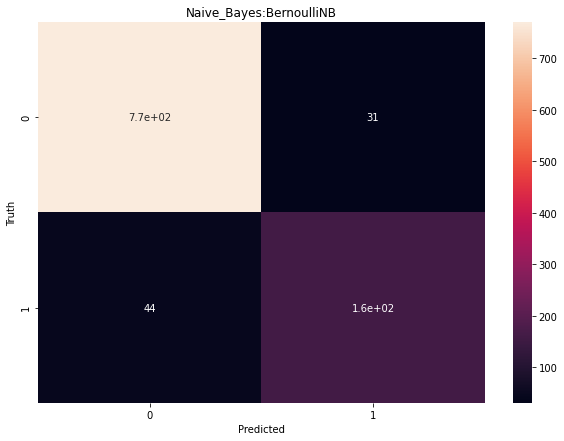

In [10]:
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt

#Confusion matrix of best classification results of the models
for model_name,matrix in ConfusionMatrix.items():
    #print(model_name)
    plt.figure(figsize = (10,7))
    sn.heatmap(matrix, annot=True)
    plt.title(model_name)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
